# Introduction to DataFrames
**[Bogumił Kamiński](http://bogumilkaminski.pl/about/), November 20, 2020**

In [1]:
using DataFrames

## Load and save DataFrames
We do not cover all features of the packages. Please refer to their documentation to learn them.

Here we'll load CSV.jl to read and write CSV files and Arrow.jl, JLSO.jl, and serialization, which allow us to work with a binary format and JSONTables.jl for JSON interaction. Finally we consider a custom JDF.jl format.

In [2]:
using Arrow
using CSV
using Serialization
using JLSO
using JSONTables
using CodecZlib
using ZipFile
using JDF
using StatsPlots # for charts
using Mmap # for compression

Let's create a simple `DataFrame` for testing purposes,

In [3]:
x = DataFrame(A=[true, false, true], B=[1, 2, missing],
              C=[missing, "b", "c"], D=['a', missing, 'c'])

,A,B,C,D
,Bool,Int64?,String?,Char?
1,1,1,missing,a
2,0,2,b,missing
3,1,missing,c,c


and use `eltypes` to look at the columnwise types.

In [4]:
eltype.(eachcol(x))

4-element Array{Type,1}:
 Bool
 Union{Missing, Int64}
 Union{Missing, String}
 Union{Missing, Char}

### CSV.jl

Let's use `CSV` to save `x` to disk; make sure `x1.csv` does not conflict with some file in your working directory.

In [5]:
CSV.write("x1.csv", x)

"x1.csv"

Now we can see how it was saved by reading `x.csv`.

In [6]:
print(read("x1.csv", String))

A,B,C,D
true,1,,a
false,2,b,
true,,c,c


We can also load it back (`use_mmap=false` disables memory mapping so that on Windows the file can be deleted in the same session, on other OSs it is not needed).

In [7]:
y = CSV.read("x1.csv", DataFrame)

,A,B,C,D
,Bool,Int64?,String?,String?
1,1,1,missing,a
2,0,2,b,missing
3,1,missing,c,c


Note that when loading in a `DataFrame` from a `CSV` the column type for column `:D` has changed!

In [8]:
eltype.(eachcol(y))

4-element Array{Type,1}:
 Bool
 Union{Missing, Int64}
 Union{Missing, String}
 Union{Missing, String}

### Serialization, JDF.jl, and JLSO.jl

#### Serialization

Now we use serialization to save `x`.

There are two ways to perform serialization. The first way is to use the `Serialization.serialize` as below:

Note that in general, this process will not work if the reading and writing are done by different versions of Julia, or an instance of Julia with a different system image.

In [9]:
open("x.bin", "w") do io
    serialize(io, x)
end

Now we load back the saved file to `y` variable. Again `y` is identical to `x`. However, please beware that if you session does not have DataFrames.jl loaded, then it may not recognise the content as DataFrames.jl

In [10]:
y = open(deserialize, "x.bin")

,A,B,C,D
,Bool,Int64?,String?,Char?
1,1,1,missing,a
2,0,2,b,missing
3,1,missing,c,c


In [11]:
eltype.(eachcol(y))

4-element Array{Type,1}:
 Bool
 Union{Missing, Int64}
 Union{Missing, String}
 Union{Missing, Char}

#### JDF.jl

[JDF.jl](https://github.com/xiaodaigh/JDF) is a relatively new package designed to serialize DataFrames. You can save a DataFrame with the `savejdf` function.

In [12]:
savejdf("x.jdf", x);

To load the saved JDF file, one can use the `loadjdf` function

In [13]:
x_loaded = loadjdf("x.jdf")

,A,B,C,D
,Bool,Int64?,String?,Char?
1,1,1,missing,a
2,0,2,b,missing
3,1,missing,c,c


You can see that they are the same

In [14]:
isequal(x_loaded, x)

true

JDF.jl offers the ability to load only certain columns from disk to help with working with large files

In [15]:
# set up a JDFFile which is a on disk representation of `x` backed by JDF.jl
x_ondisk = jdf"x.jdf"

JDFFile{String}("x.jdf")

We can see all the names of `x` without loading it into memory

In [16]:
names(x_ondisk)

4-element Array{String,1}:
 "A"
 "B"
 "C"
 "D"

The below is an example of how to load only columns `:A` and `:D` 

In [17]:
xd = sloadjdf(x_ondisk; cols = ["A", "D"])

,A,D
,Bool,Char?
1,1,a
2,0,missing
3,1,c


##### JDF.jl vs others

JDF.jl is specialized to DataFrames.jl and only supports a restricted list of columns, so it can not save data frames with arbitrary column types. However, this also means that JDF.jl has specialised algorithms to serailize the type it supports to optimize speed, minimize disk usage, and reduce the chance of errors

The list support columns for JDF include

```julia
WeakRefStrings.StringVector
Vector{T}, Vector{Union{Mising, T}}, Vector{Union{Nothing, T}}
CategoricalArrays.CategoricalVetors{T}
```

where `T` can be `String`, `Bool`, `Symbol`, `Char`, `TimeZones.ZonedDateTime` (experimental) and `isbit`s types i.e. `UInt*`, `Int*`, `Float*`, and `Date*` types etc.

#### JLSO.jl

Another way to perform serialization is by using the [JLSO.jl](https://github.com/invenia/JLSO.jl) library:

In [18]:
JLSO.save("x.jlso", :data => x)

Now we can laod back the file to `y`

In [19]:
y = JLSO.load("x.jlso")[:data]

,A,B,C,D
,Bool,Int64?,String?,Char?
1,1,1,missing,a
2,0,2,b,missing
3,1,missing,c,c


In [20]:
eltype.(eachcol(y))

4-element Array{Type,1}:
 Bool
 Union{Missing, Int64}
 Union{Missing, String}
 Union{Missing, Char}

### JSONTables.jl

Often you might need to read and write data stored in JSON format. JSONTables.jl provides a way to process them in row-oriented or column-oriented layout. We present both options below.

In [21]:
open(io -> arraytable(io, x), "x1.json", "w")

106

In [22]:
open(io -> objecttable(io, x), "x2.json", "w")

76

In [23]:
print(read("x1.json", String))

[{"A":true,"B":1,"C":null,"D":"a"},{"A":false,"B":2,"C":"b","D":null},{"A":true,"B":null,"C":"c","D":"c"}]

In [24]:
print(read("x2.json", String))

{"A":[true,false,true],"B":[1,2,null],"C":[null,"b","c"],"D":["a",null,"c"]}

In [25]:
y1 = open(jsontable, "x1.json") |> DataFrame

,A,B,C,D
,Bool,Int64?,String?,String?
1,1,1,missing,a
2,0,2,b,missing
3,1,missing,c,c


In [26]:
eltype.(eachcol(y1))

4-element Array{Type,1}:
 Bool
 Union{Missing, Int64}
 Union{Missing, String}
 Union{Missing, String}

In [27]:
y2 = open(jsontable, "x2.json") |> DataFrame

,A,B,C,D
,Bool,Int64?,String?,String?
1,1,1,missing,a
2,0,2,b,missing
3,1,missing,c,c


In [28]:
eltype.(eachcol(y2))

4-element Array{Type,1}:
 Bool
 Union{Missing, Int64}
 Union{Missing, String}
 Union{Missing, String}

### Arrow.jl

Finally we use Apache Arrow format that allows, in particular, for data interchange with R or Python.

In [29]:
Arrow.write("x.arrow", x)

"x.arrow"

In [30]:
y = Arrow.Table("x.arrow") |> DataFrame

,A,B,C,D
,Bool,Int64?,String?,Char?
1,1,1,missing,a
2,0,2,b,missing
3,1,missing,c,c


In [31]:
eltype.(eachcol(y))

4-element Array{Type,1}:
 Bool
 Union{Missing, Int64}
 Union{Missing, String}
 Union{Missing, Char}

Note that columns of `y` are immutable

In [32]:
y.A[1] = false

LoadError: ReadOnlyMemoryError()

This is because `Arrow.Table` uses memory mapping and thus uses a custom vector types:

In [33]:
y.A

3-element Arrow.BoolVector{Bool}:
 1
 0
 1

In [34]:
y.B

3-element Arrow.Primitive{Union{Missing, Int64},Array{Int64,1}}:
 1
 2
  missing

You can get standard Julia Base vectors by copying a data frame

In [35]:
y2 = copy(y)

,A,B,C,D
,Bool,Int64?,String?,Char?
1,1,1,missing,a
2,0,2,b,missing
3,1,missing,c,c


In [36]:
y2.A

3-element Array{Bool,1}:
 1
 0
 1

In [37]:
y2.B

3-element Array{Union{Missing, Int64},1}:
 1
 2
  missing

### Basic bechmarking

Next, we'll create some files, so be careful that you don't already have these files in your working directory!

In particular, we'll time how long it takes us to write a `DataFrame` with 10^3 rows and 10^5 columns.

In [38]:
bigdf = DataFrame(rand(Bool, 10^5, 500), :auto)
bigdf[!, 1] = Int.(bigdf[!, 1])
bigdf[!, 2] = bigdf[!, 2] .+ 0.5
bigdf[!, 3] = string.(bigdf[!, 3], ", as string")
println("First run")
println("CSV.jl")
csvwrite1 = @elapsed @time CSV.write("bigdf1.csv", bigdf)
println("Serialization")
serializewrite1 = @elapsed @time open(io -> serialize(io, bigdf), "bigdf.bin", "w")
println("JDF.jl")
jdfwrite1 = @elapsed @time savejdf("bigdf.jdf", bigdf)
println("JLSO.jl")
jlsowrite1 = @elapsed @time JLSO.save("bigdf.jlso", :data => bigdf)
println("Arrow.jl")
arrowwrite1 = @elapsed @time Arrow.write("bigdf.arrow", bigdf)
println("JSONTables.jl arraytable")
jsontablesawrite1 = @elapsed @time open(io -> arraytable(io, bigdf), "bigdf1.json", "w")
println("JSONTables.jl objecttable")
jsontablesowrite1 = @elapsed @time open(io -> objecttable(io, bigdf), "bigdf2.json", "w")
println("Second run")
println("CSV.jl")
csvwrite2 = @elapsed @time CSV.write("bigdf1.csv", bigdf)
println("Serialization")
serializewrite2 = @elapsed @time open(io -> serialize(io, bigdf), "bigdf.bin", "w")
println("JDF.jl")
jdfwrite2 = @elapsed @time savejdf("bigdf.jdf", bigdf)
println("JLSO.jl")
jlsowrite2 = @elapsed @time JLSO.save("bigdf.jlso", :data => bigdf)
println("Arrow.jl")
arrowwrite2 = @elapsed @time Arrow.write("bigdf.arrow", bigdf)
println("JSONTables.jl arraytable")
jsontablesawrite2 = @elapsed @time open(io -> arraytable(io, bigdf), "bigdf1.json", "w")
println("JSONTables.jl objecttable")
jsontablesowrite2 = @elapsed @time open(io -> objecttable(io, bigdf), "bigdf2.json", "w")

First run
CSV.jl
 18.336468 seconds (251.61 M allocations: 8.272 GiB, 8.55% gc time)
Serialization
  1.292221 seconds (281.32 k allocations: 11.391 MiB)
JDF.jl
  3.174406 seconds (98.22 k allocations: 167.224 MiB, 0.84% gc time)
JLSO.jl
  4.622379 seconds (364.15 k allocations: 31.849 MiB)
Arrow.jl
  1.714735 seconds (3.91 M allocations: 210.636 MiB, 1.96% gc time)
JSONTables.jl arraytable
144.985897 seconds (1.30 G allocations: 227.096 GiB, 13.14% gc time)
JSONTables.jl objecttable
  2.078348 seconds (363.09 k allocations: 1.587 GiB, 4.75% gc time)
Second run
CSV.jl
 17.975779 seconds (249.94 M allocations: 8.199 GiB, 6.94% gc time)
Serialization
  1.281253 seconds (105.69 k allocations: 2.292 MiB)
JDF.jl
  2.195526 seconds (27.08 k allocations: 163.650 MiB)
JLSO.jl
  4.601957 seconds (139.77 k allocations: 20.918 MiB)
Arrow.jl
  0.405740 seconds (123.71 k allocations: 14.419 MiB, 8.80% gc time)
JSONTables.jl arraytable
149.474199 seconds (1.30 G allocations: 227.064 GiB, 11.89% gc ti

1.413189399

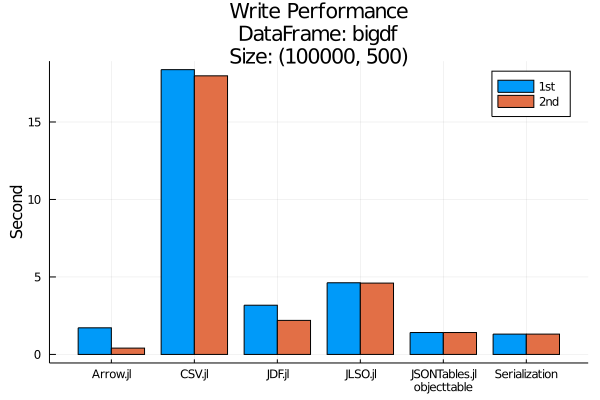

In [39]:
groupedbar(
    # Exclude JSONTables.jl arraytable due to timing
    repeat(["CSV.jl", "Serialization", "JDF.jl", "JLSO.jl", "Arrow.jl", "JSONTables.jl\nobjecttable"],
            inner = 2),
    [csvwrite1, csvwrite2, serializewrite1, serializewrite1, jdfwrite1, jdfwrite2,
     jlsowrite1, jlsowrite2, arrowwrite1, arrowwrite2, jsontablesowrite2, jsontablesowrite2],
    group = repeat(["1st", "2nd"], outer = 6),
    ylab = "Second",
    title = "Write Performance\nDataFrame: bigdf\nSize: $(size(bigdf))"
)

In [40]:
data_files = ["bigdf1.csv", "bigdf.bin", "bigdf.arrow", "bigdf1.json", "bigdf2.json"]
df = DataFrame(file = data_files, size = getfield.(stat.(data_files), :size))
append!(df, DataFrame(file = "bigdf.jdf", size=reduce((x,y)->x+y.size,
                                                      stat.(joinpath.("bigdf.jdf", readdir("bigdf.jdf"))),
                                                      init=0)))
sort!(df, :size)

,file,size
,String,Int64
1,bigdf.arrow,9832362
2,bigdf.jdf,26010830
3,bigdf.bin,26765489
4,bigdf1.csv,275804508
5,bigdf2.json,275806509
6,bigdf1.json,615202117


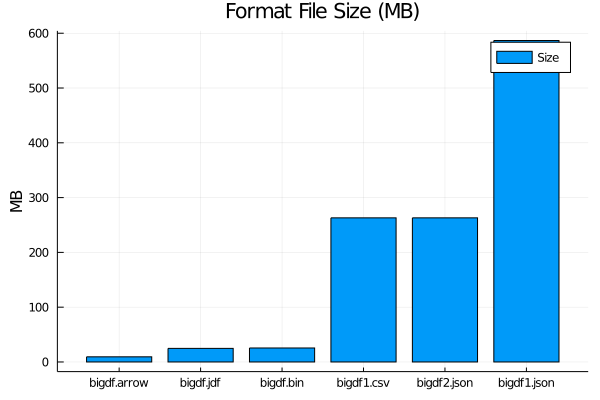

In [41]:
@df df plot(:file, :size/1024^2, seriestype=:bar, title = "Format File Size (MB)", label="Size", ylab="MB")

In [42]:
println("First run")
println("CSV.jl")
csvread1 = @elapsed @time CSV.read("bigdf1.csv", DataFrame)
println("Serialization")
serializeread1 = @elapsed @time open(deserialize, "bigdf.bin")
println("JDF.jl")
jdfread1 = @elapsed @time loadjdf("bigdf.jdf")
println("JLSO.jl")
jlsoread1 = @elapsed @time JLSO.load("bigdf.jlso")
println("Arrow.jl")
arrowread1 = @elapsed @time df_tmp = Arrow.Table("bigdf.arrow") |> DataFrame
arrowread1copy = @elapsed @time copy(df_tmp)
println("JSONTables.jl arraytable")
jsontablesaread1 = @elapsed @time open(jsontable, "bigdf1.json")
println("JSONTables.jl objecttable")
jsontablesoread1 = @elapsed @time open(jsontable, "bigdf2.json")
println("Second run")
csvread2 = @elapsed @time CSV.read("bigdf1.csv", DataFrame)
println("Serialization")
serializeread2 = @elapsed @time open(deserialize, "bigdf.bin")
println("JDF.jl")
jdfread2 = @elapsed @time loadjdf("bigdf.jdf")
println("JLSO.jl")
jlsoread2 = @elapsed @time JLSO.load("bigdf.jlso")
println("Arrow.jl")
arrowread2 = @elapsed @time df_tmp = Arrow.Table("bigdf.arrow") |> DataFrame
arrowread2copy = @elapsed @time copy(df_tmp)
println("JSONTables.jl arraytable")
jsontablesaread2 = @elapsed @time open(jsontable, "bigdf1.json")
println("JSONTables.jl objecttable")
jsontablesoread2 = @elapsed @time open(jsontable, "bigdf2.json");

First run
CSV.jl
  2.607400 seconds (928.84 k allocations: 202.391 MiB)
Serialization
  2.710477 seconds (49.56 M allocations: 806.986 MiB, 11.29% gc time)
JDF.jl
  0.676249 seconds (192.12 k allocations: 156.729 MiB, 9.14% gc time)
JLSO.jl
  1.975146 seconds (49.68 M allocations: 818.153 MiB, 6.09% gc time)
Arrow.jl
  0.193021 seconds (287.39 k allocations: 14.699 MiB)
  1.084494 seconds (335.84 k allocations: 66.043 MiB)
JSONTables.jl arraytable
  4.053238 seconds (27 allocations: 2.144 GiB, 6.48% gc time)
JSONTables.jl objecttable
  2.621731 seconds (2.50 k allocations: 1.156 GiB, 11.33% gc time)
Second run
  2.314200 seconds (6.22 k allocations: 155.171 MiB, 4.05% gc time)
Serialization
  2.343229 seconds (49.55 M allocations: 806.356 MiB, 3.73% gc time)
JDF.jl
  0.449178 seconds (34.62 k allocations: 148.844 MiB, 1.13% gc time)
JLSO.jl
  1.868072 seconds (49.67 M allocations: 817.597 MiB, 4.71% gc time)
Arrow.jl
  0.002340 seconds (31.11 k allocations: 1.693 MiB)
  0.905664 second

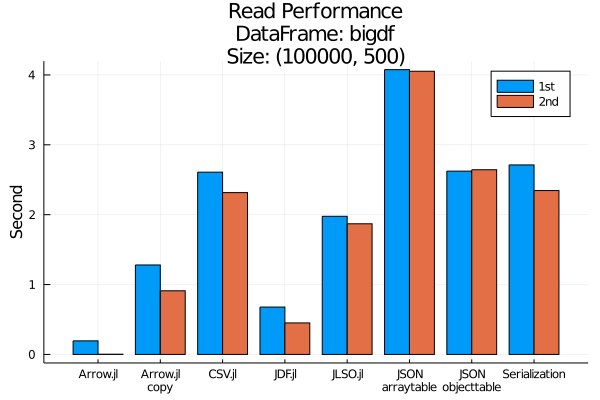

In [43]:
groupedbar(
    repeat(["CSV.jl", "Serialization", "JDF.jl", "JLSO.jl", "Arrow.jl", "Arrow.jl\ncopy", "JSON\narraytable",
            "JSON\nobjecttable"], inner = 2),
    [csvread1, csvread2, serializeread1, serializeread2, jdfread1, jdfread2, jlsoread1, jlsoread2,
     arrowread1, arrowread2, arrowread1+arrowread1copy, arrowread2+arrowread2copy,
     jsontablesaread1, jsontablesaread2, jsontablesoread1, jsontablesoread2],    
    group = repeat(["1st", "2nd"], outer = 8),
    ylab = "Second",
    title = "Read Performance\nDataFrame: bigdf\nSize: $(size(bigdf))"
)

### Using gzip compression

A common user requirement is to be able to load and save CSV that are compressed using gzip.
Below we show how this can be accomplished using CodecZlib.jl.
The same pattern is applicable to JSONTables.jl compression/decompression.

Again make sure that you do not have file named `df_compress_test.csv.gz` in your working directory

We first generate a random data frame

In [44]:
df = DataFrame(rand(1:10, 10, 1000), :auto)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,10,2,9,9,2,4,8,6,1,7,8,1
2,2,6,2,8,3,8,6,3,10,5,5,1
3,1,5,3,7,5,7,7,1,5,7,10,7
4,9,10,10,7,1,5,6,5,9,6,7,10
5,1,10,8,7,5,8,2,1,10,9,5,1
6,2,6,7,8,10,4,4,4,3,8,5,5
7,8,7,10,8,9,2,3,3,5,2,9,7
8,5,8,4,6,7,6,3,4,8,7,7,8
9,8,8,5,1,5,5,6,5,4,8,4,7


In [45]:
# GzipCompressorStream comes from CodecZlib

open("df_compress_test.csv.gz", "w") do io
    stream = GzipCompressorStream(io)
    CSV.write(stream, df)
    close(stream)
end

In [46]:
df2 = CSV.File(transcode(GzipDecompressor, Mmap.mmap("df_compress_test.csv.gz"))) |> DataFrame

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,10,2,9,9,2,4,8,6,1,7,8,1
2,2,6,2,8,3,8,6,3,10,5,5,1
3,1,5,3,7,5,7,7,1,5,7,10,7
4,9,10,10,7,1,5,6,5,9,6,7,10
5,1,10,8,7,5,8,2,1,10,9,5,1
6,2,6,7,8,10,4,4,4,3,8,5,5
7,8,7,10,8,9,2,3,3,5,2,9,7
8,5,8,4,6,7,6,3,4,8,7,7,8
9,8,8,5,1,5,5,6,5,4,8,4,7


In [47]:
df == df2

true

### Using zip files

Sometimes you may have files compressed inside a zip file.

In such a situation you may use [ZipFile.jl](https://github.com/fhs/ZipFile.jl) in conjunction an an appropriate reader to read the files.

Here we first create a ZIP file and then read back its contents into a `DataFrame`.

In [48]:
df1 = DataFrame(rand(1:10, 3, 4), :auto)

,x1,x2,x3,x4
,Int64,Int64,Int64,Int64
1,9,10,9,1
2,4,1,1,6
3,1,5,8,10


In [49]:
df2 = DataFrame(rand(1:10, 3, 4), :auto)

,x1,x2,x3,x4
,Int64,Int64,Int64,Int64
1,3,4,2,2
2,10,3,9,3
3,7,7,8,6


And we show yet another way to write a `DataFrame` into a CSV file

In [50]:
# write a CSV file into the zip file
w = ZipFile.Writer("x.zip")

f1 = ZipFile.addfile(w, "x1.csv")
write(f1, sprint(show, "text/csv", df1))

# write a second CSV file into zip file
f2 = ZipFile.addfile(w, "x2.csv", method=ZipFile.Deflate)
write(f2, sprint(show, "text/csv", df2))

close(w)

Now we read the CSV we have written:

In [51]:
z = ZipFile.Reader("x.zip");

In [52]:
# find the index index of file called x1.csv
index_xcsv = findfirst(x->x.name == "x1.csv", z.files)
# to read the x1.csv file in the zip file
df1_2 = CSV.read(read(z.files[index_xcsv]), DataFrame)

,x1,x2,x3,x4
,Int64,Int64,Int64,Int64
1,9,10,9,1
2,4,1,1,6
3,1,5,8,10


In [53]:
df1_2 == df1

true

In [54]:
# find the index index of file called x2.csv
index_xcsv = findfirst(x->x.name == "x2.csv", z.files)
# to read the x2.csv file in the zip file
df2_2 = CSV.read(read(z.files[index_xcsv]), DataFrame)

,x1,x2,x3,x4
,Int64,Int64,Int64,Int64
1,3,4,2,2
2,10,3,9,3
3,7,7,8,6


In [55]:
df2_2 == df2

true

Note that once you read a given file from `z` object its stream is all used-up (it is at its end). Therefore to read it again you need to close `z` and open it again.

Also do not forget to close the zip file once done.

In [56]:
close(z)

Finally, let's clean up. Do not run the next cell unless you are sure that it will not erase your important files.

In [57]:
foreach(rm, ["x1.csv", "x.bin", "x.jlso", "x1.json", "x2.json",
             "bigdf1.csv", "bigdf.bin", "bigdf.jlso", "bigdf1.json", "bigdf2.json", 
             "x.zip"])

In [58]:
rm("bigdf.jdf", recursive=true)
rm("x.jdf", recursive=true)

Note that we did not remove `x.arrow` and `bigdf.arrow` and `df_compress_test.csv.gz` - you have to do it manually, as these files are memory mapped.